In [1]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-rjutc18u
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-rjutc18u
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit 2ec2f1aa73e3976553b1ddcb4245a42052a59138
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
import sys
import cv2
import glob
import math
import time
import timm
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from torch import nn, optim
from torchinfo import summary
from tabulate import tabulate
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.image as mpimg
from torchvision import transforms
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import LambdaLR
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [3]:
from torch.utils.data import DataLoader, Dataset 
import torchvision
import torchvision.transforms.v2 as v2 


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

In [6]:
dir_path = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'
test_ds = os.path.join(dir_path, 'test')
train_ds = os.path.join(dir_path, 'train')

In [7]:
train = ImageFolder(train_ds)
test = ImageFolder(test_ds)

class_map = {0:'Mild Demented', 1:'Moderate Demented', 2:'Non Demented', 3:'Very Mild Demented'}
class_dict = dict(Counter(train.targets))
class_dict

{0: 717, 1: 52, 2: 2560, 3: 1792}

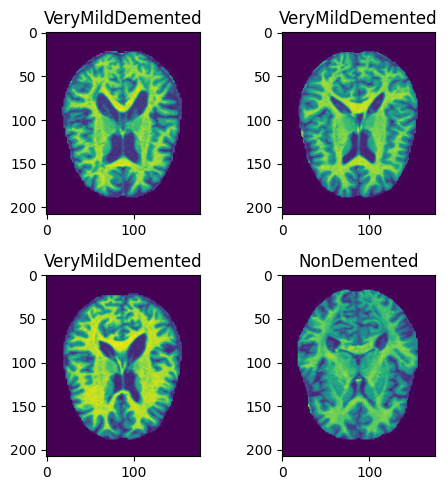

In [8]:
image_paths = []
for path in train.imgs:
    image_paths.append(path[0])
shuffled = image_paths.copy()    
random.shuffle(shuffled)
plt.figure(figsize=(5,5))
for i, path in enumerate(shuffled):
    if i>3: break
    plt.subplot(2,2,i+1)
    img = Image.open(path)
    image_class = Path(path).parent.stem
    plt.title(image_class)
    plt.imshow(img)
plt.tight_layout()

In [9]:
class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = Image.open(self.dataset[idx][0])
        class_category = self.dataset[idx][1]
        if self.transform:
            image = self.transform(image)
        return image, class_category

In [10]:
transforms.functional.get_image_size(Image.open(train.imgs[1][0]))

[176, 208]

In [11]:
torchvision.transforms.functional.get_image_num_channels(Image.open(train.imgs[1][0]))

1

In [12]:
train_transform = v2.Compose([
                v2.Resize((224,224)),
                transforms.Grayscale(num_output_channels=3),
                v2.ToTensor()
])

test_transform = v2.Compose([
                v2.Resize((224,224)),
                transforms.Grayscale(num_output_channels=3),
                v2.ToTensor()
])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [13]:
train_data, train_label = train.imgs, train.targets
test_data, test_label = test.imgs, test.targets

#os.path.join(dir_path,train_data)
train_dataset = ImageLoader(train_data, train_transform)
test_dataset = ImageLoader(test_data, test_transform)

In [14]:
train_dataset

In [15]:
import torch
from torch.utils.data import Subset, ConcatDataset
from sklearn.model_selection import StratifiedShuffleSplit

# Merge train and test data and labels
all_data = ConcatDataset([train_dataset, test_dataset])

# Extract labels from the combined dataset
labels = [label for _, label in all_data]

# Perform stratified shuffle split for train and test
sss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices_1, test_indices = next(sss_train_test.split(torch.zeros(len(labels)), labels))

# Create Subset objects for train and test sets
train_data_1 = Subset(all_data, train_indices_1)
test_data = Subset(all_data, test_indices)

# Extract labels from the train subset for train-validation split
train_labels_1 = [label for _, label in train_data_1]

# Perform stratified shuffle split for train and validation
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, val_indices = next(sss_train_val.split(torch.zeros(len(train_labels_1)), train_labels_1))

# Create Subset objects for train and validation sets
train_data = Subset(train_data_1, train_indices)
val_data = Subset(train_data_1, val_indices)


In [16]:
from collections import defaultdict

# Define a dictionary to store the counts of images in each class
train_class_counts = defaultdict(int)
val_class_counts = defaultdict(int)
test_class_counts = defaultdict(int)

# Iterate over train_data and count the occurrences of each class label
for _, label in train_data:
    train_class_counts[label] += 1

# Iterate over val_data and count the occurrences of each class label
for _, label in val_data:
    val_class_counts[label] += 1

# Iterate over test_data and count the occurrences of each class label
for _, label in test_data:
    test_class_counts[label] += 1

# Print the counts for train, val, and test datasets
print("Train Dataset Class Counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nValidation Dataset Class Counts:")
for class_label, count in val_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nTest Dataset Class Counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} images")


Train Dataset Class Counts:
Class 2: 2048 images
Class 3: 1433 images
Class 0: 574 images
Class 1: 41 images

Validation Dataset Class Counts:
Class 2: 512 images
Class 3: 359 images
Class 0: 143 images
Class 1: 10 images

Test Dataset Class Counts:
Class 3: 448 images
Class 0: 179 images
Class 2: 640 images
Class 1: 13 images


**Data loaded after stratified shuffle split**

In [17]:
train_loader = DataLoader(train_data, batch_size=64)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [18]:
num_classes = 4
model = timm.create_model('pit_ti_224', pretrained=True)
model.head = torch.nn.Linear(model.head.in_features, num_classes)
model.to(device)
summary(model, (3, 224, 224))  # Assumes input images of size (3, 224, 224)

model.safetensors:   0%|          | 0.00/19.4M [00:00<?, ?B/s]

Layer (type:depth-idx)                             Output Shape              Param #
PoolingVisionTransformer                           [1, 4]                    46,720
├─ConvEmbedding: 1-1                               [64, 27, 27]              --
│    └─Conv2d: 2-1                                 [64, 27, 27]              49,216
├─Dropout: 1-2                                     [1, 64, 27, 27]           --
├─SequentialTuple: 1-3                             [1, 256, 7, 7]            --
│    └─Transformer: 2-2                            [1, 64, 27, 27]           --
│    │    └─Identity: 3-1                          [1, 730, 64]              --
│    │    └─Sequential: 3-2                        [1, 730, 64]              99,968
│    └─Transformer: 2-3                            [1, 128, 14, 14]          --
│    │    └─Pooling: 3-3                           [1, 128, 14, 14]          9,600
│    │    └─Identity: 3-4                          [1, 197, 128]             --
│    │    └─Sequenti

In [19]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    # Calculate predicted class labels
    y_pred_classes = torch.argmax(y_pred, dim=1)

    # Calculate accuracy using predicted and true labels
    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    # Compute confusion matrix for multiclass classification
    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    
    # Calculate specificity, sensitivity, and MCC for multiclass classification
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    # Calculate AUC for each class
    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    # Average AUC across classes
    auc_avg = np.mean(auc_scores)

    # Create a dictionary to store metrics
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [20]:
# Define the loss function and optimizer
from torch.optim.lr_scheduler import StepLR

# scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00095)

In [21]:
total_epochs = 50

# Initialize lists to store metric values for each epoch
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score", "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

# Training and validation loop
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(total_epochs):
    start_time = time.time()
    
    # Training phase
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{total_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
        all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    average_loss = total_loss / len(train_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print training metrics in one line
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{training_metrics_line}")

    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])

    # Validation phase
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    average_loss = total_loss / len(val_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print validation metrics in one line
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{validation_metrics_line}")
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])
    
#     scheduler.step()

# Calculate and display total time taken for training and validation
print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

# Calculate and display average time taken per epoch for training and validation
avg_training_time_per_epoch = total_training_time / total_epochs
avg_validation_time_per_epoch = total_validation_time / total_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/50]: 100%|██████████| 64/64 [00:18<00:00,  3.51it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0936, accuracy: 0.4629, precision: 0.3681, recall: 0.4629, f1_score: 0.3949, specificity: 0.0000, sensitivity: 1.0000, mcc: -0.0089, auc: 0.5017


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.26it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0672, accuracy: 0.5000, precision: 0.2500, recall: 0.5000, f1_score: 0.3333, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6576


Training Model - Epoch [2/50]: 100%|██████████| 64/64 [00:18<00:00,  3.47it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0377, accuracy: 0.4912, precision: 0.3697, recall: 0.4912, f1_score: 0.3707, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0108, auc: 0.5322


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9806, accuracy: 0.5107, precision: 0.4313, recall: 0.5107, f1_score: 0.4676, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.1294, auc: 0.6556


Training Model - Epoch [3/50]: 100%|██████████| 64/64 [00:18<00:00,  3.47it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0297, accuracy: 0.4893, precision: 0.4150, recall: 0.4893, f1_score: 0.4114, specificity: 0.0087, sensitivity: 0.9935, mcc: 0.0430, auc: 0.5568


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.63it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9866, accuracy: 0.5098, precision: 0.4553, recall: 0.5098, f1_score: 0.4764, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.1573, auc: 0.6653


Training Model - Epoch [4/50]: 100%|██████████| 64/64 [00:17<00:00,  3.64it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0186, accuracy: 0.4983, precision: 0.4395, recall: 0.4983, f1_score: 0.4402, specificity: 0.0070, sensitivity: 0.9963, mcc: 0.0811, auc: 0.5890


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.23it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0075, accuracy: 0.5020, precision: 0.6011, recall: 0.5020, f1_score: 0.3377, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0461, auc: 0.6883


Training Model - Epoch [5/50]: 100%|██████████| 64/64 [00:18<00:00,  3.53it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9711, accuracy: 0.5134, precision: 0.4685, recall: 0.5134, f1_score: 0.4704, specificity: 0.0436, sensitivity: 0.9832, mcc: 0.1284, auc: 0.6447


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9432, accuracy: 0.5498, precision: 0.5159, recall: 0.5498, f1_score: 0.5165, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.2551, auc: 0.7082


Training Model - Epoch [6/50]: 100%|██████████| 64/64 [00:17<00:00,  3.57it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9301, accuracy: 0.5376, precision: 0.5069, recall: 0.5376, f1_score: 0.5078, specificity: 0.0436, sensitivity: 0.9815, mcc: 0.1976, auc: 0.6857


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.52it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9343, accuracy: 0.5586, precision: 0.5086, recall: 0.5586, f1_score: 0.5232, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.2566, auc: 0.7269


Training Model - Epoch [7/50]: 100%|██████████| 64/64 [00:17<00:00,  3.56it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9148, accuracy: 0.5532, precision: 0.5403, recall: 0.5532, f1_score: 0.5181, specificity: 0.0296, sensitivity: 0.9940, mcc: 0.2220, auc: 0.7053


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.59it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8944, accuracy: 0.5654, precision: 0.5149, recall: 0.5654, f1_score: 0.5307, specificity: 0.0000, sensitivity: 0.9977, mcc: 0.2671, auc: 0.7346


Training Model - Epoch [8/50]: 100%|██████████| 64/64 [00:18<00:00,  3.53it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9042, accuracy: 0.5591, precision: 0.5456, recall: 0.5591, f1_score: 0.5331, specificity: 0.0767, sensitivity: 0.9827, mcc: 0.2395, auc: 0.7144


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8923, accuracy: 0.5410, precision: 0.4384, recall: 0.5410, f1_score: 0.4721, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.1645, auc: 0.7434


Training Model - Epoch [9/50]: 100%|██████████| 64/64 [00:17<00:00,  3.58it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8943, accuracy: 0.5669, precision: 0.5566, recall: 0.5669, f1_score: 0.5380, specificity: 0.0592, sensitivity: 0.9878, mcc: 0.2538, auc: 0.7337


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.61it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8542, accuracy: 0.5703, precision: 0.5764, recall: 0.5703, f1_score: 0.5386, specificity: 0.0490, sensitivity: 0.9943, mcc: 0.2560, auc: 0.7767


Training Model - Epoch [10/50]: 100%|██████████| 64/64 [00:17<00:00,  3.59it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8746, accuracy: 0.5676, precision: 0.5593, recall: 0.5676, f1_score: 0.5477, specificity: 0.1098, sensitivity: 0.9753, mcc: 0.2620, auc: 0.7532


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.02it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8469, accuracy: 0.5693, precision: 0.5801, recall: 0.5693, f1_score: 0.5654, specificity: 0.2028, sensitivity: 0.9387, mcc: 0.2907, auc: 0.7962


Training Model - Epoch [11/50]: 100%|██████████| 64/64 [00:18<00:00,  3.54it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8517, accuracy: 0.5864, precision: 0.5827, recall: 0.5864, f1_score: 0.5732, specificity: 0.1951, sensitivity: 0.9679, mcc: 0.2971, auc: 0.7764


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.50it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8917, accuracy: 0.5723, precision: 0.6257, recall: 0.5723, f1_score: 0.5744, specificity: 0.3287, sensitivity: 0.9432, mcc: 0.3270, auc: 0.7966


Training Model - Epoch [12/50]: 100%|██████████| 64/64 [00:18<00:00,  3.53it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8424, accuracy: 0.5859, precision: 0.5834, recall: 0.5859, f1_score: 0.5758, specificity: 0.2178, sensitivity: 0.9608, mcc: 0.3001, auc: 0.7840


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.46it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8276, accuracy: 0.5918, precision: 0.6346, recall: 0.5918, f1_score: 0.5923, specificity: 0.3077, sensitivity: 0.9455, mcc: 0.3520, auc: 0.8183


Training Model - Epoch [13/50]: 100%|██████████| 64/64 [00:17<00:00,  3.56it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8226, accuracy: 0.6028, precision: 0.6100, recall: 0.6028, f1_score: 0.5990, specificity: 0.3014, sensitivity: 0.9540, mcc: 0.3392, auc: 0.7988


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8494, accuracy: 0.5771, precision: 0.6177, recall: 0.5771, f1_score: 0.5750, specificity: 0.2517, sensitivity: 0.9591, mcc: 0.3206, auc: 0.7923


Training Model - Epoch [14/50]: 100%|██████████| 64/64 [00:17<00:00,  3.56it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8107, accuracy: 0.6033, precision: 0.6072, recall: 0.6033, f1_score: 0.6002, specificity: 0.3240, sensitivity: 0.9469, mcc: 0.3398, auc: 0.8092


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.64it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8197, accuracy: 0.5967, precision: 0.6336, recall: 0.5967, f1_score: 0.6017, specificity: 0.4406, sensitivity: 0.9274, mcc: 0.3599, auc: 0.8246


Training Model - Epoch [15/50]: 100%|██████████| 64/64 [00:17<00:00,  3.56it/s]


Metrics - loss: 0.7612, accuracy: 0.6394, precision: 0.6557, recall: 0.6394, f1_score: 0.6396, specificity: 0.4129, sensitivity: 0.9500, mcc: 0.4061, auc: 0.8355


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.62it/s]


Metrics - loss: 0.7942, accuracy: 0.6211, precision: 0.6393, recall: 0.6211, f1_score: 0.6257, specificity: 0.5105, sensitivity: 0.9330, mcc: 0.3817, auc: 0.8254


Training Model - Epoch [16/50]: 100%|██████████| 64/64 [00:18<00:00,  3.55it/s]


Metrics - loss: 0.7628, accuracy: 0.6350, precision: 0.6451, recall: 0.6350, f1_score: 0.6353, specificity: 0.4408, sensitivity: 0.9492, mcc: 0.3963, auc: 0.8391


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.50it/s]


Metrics - loss: 0.8204, accuracy: 0.5840, precision: 0.6447, recall: 0.5840, f1_score: 0.5968, specificity: 0.6224, sensitivity: 0.8547, mcc: 0.3607, auc: 0.8341


Training Model - Epoch [17/50]: 100%|██████████| 64/64 [00:17<00:00,  3.58it/s]


Metrics - loss: 0.7359, accuracy: 0.6453, precision: 0.6548, recall: 0.6453, f1_score: 0.6468, specificity: 0.4721, sensitivity: 0.9443, mcc: 0.4147, auc: 0.8566


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]


Metrics - loss: 0.7842, accuracy: 0.6016, precision: 0.6051, recall: 0.6016, f1_score: 0.6026, specificity: 0.4685, sensitivity: 0.9217, mcc: 0.3427, auc: 0.8456


Training Model - Epoch [18/50]: 100%|██████████| 64/64 [00:17<00:00,  3.60it/s]


Metrics - loss: 0.7167, accuracy: 0.6646, precision: 0.6740, recall: 0.6646, f1_score: 0.6662, specificity: 0.4930, sensitivity: 0.9480, mcc: 0.4473, auc: 0.8658


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.55it/s]


Metrics - loss: 0.7831, accuracy: 0.6240, precision: 0.6432, recall: 0.6240, f1_score: 0.6296, specificity: 0.6783, sensitivity: 0.8978, mcc: 0.4039, auc: 0.8565


Training Model - Epoch [19/50]: 100%|██████████| 64/64 [00:18<00:00,  3.53it/s]


Metrics - loss: 0.6902, accuracy: 0.6782, precision: 0.6856, recall: 0.6782, f1_score: 0.6793, specificity: 0.5331, sensitivity: 0.9523, mcc: 0.4684, auc: 0.8702


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]


Metrics - loss: 0.7445, accuracy: 0.6309, precision: 0.6570, recall: 0.6309, f1_score: 0.6376, specificity: 0.6084, sensitivity: 0.9092, mcc: 0.4122, auc: 0.8667


Training Model - Epoch [20/50]: 100%|██████████| 64/64 [00:17<00:00,  3.57it/s]


Metrics - loss: 0.6415, accuracy: 0.7043, precision: 0.7130, recall: 0.7043, f1_score: 0.7064, specificity: 0.5958, sensitivity: 0.9532, mcc: 0.5143, auc: 0.8971


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.61it/s]


Metrics - loss: 0.7385, accuracy: 0.6562, precision: 0.6685, recall: 0.6562, f1_score: 0.6605, specificity: 0.6573, sensitivity: 0.9115, mcc: 0.4478, auc: 0.8644


Training Model - Epoch [21/50]: 100%|██████████| 64/64 [00:17<00:00,  3.60it/s]


Metrics - loss: 0.6378, accuracy: 0.7119, precision: 0.7157, recall: 0.7119, f1_score: 0.7129, specificity: 0.6220, sensitivity: 0.9469, mcc: 0.5270, auc: 0.8956


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]


Metrics - loss: 0.7680, accuracy: 0.6357, precision: 0.6714, recall: 0.6357, f1_score: 0.6439, specificity: 0.6993, sensitivity: 0.8797, mcc: 0.4310, auc: 0.8615


Training Model - Epoch [22/50]: 100%|██████████| 64/64 [00:18<00:00,  3.52it/s]


Metrics - loss: 0.6441, accuracy: 0.7068, precision: 0.7095, recall: 0.7068, f1_score: 0.7058, specificity: 0.6359, sensitivity: 0.9500, mcc: 0.5149, auc: 0.8949


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]


Metrics - loss: 0.7247, accuracy: 0.6680, precision: 0.6881, recall: 0.6680, f1_score: 0.6735, specificity: 0.6643, sensitivity: 0.9115, mcc: 0.4699, auc: 0.8785


Training Model - Epoch [23/50]: 100%|██████████| 64/64 [00:17<00:00,  3.57it/s]


Metrics - loss: 0.5901, accuracy: 0.7317, precision: 0.7341, recall: 0.7317, f1_score: 0.7323, specificity: 0.6463, sensitivity: 0.9543, mcc: 0.5570, auc: 0.9128


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]


Metrics - loss: 0.6891, accuracy: 0.6768, precision: 0.6915, recall: 0.6768, f1_score: 0.6810, specificity: 0.7343, sensitivity: 0.9183, mcc: 0.4858, auc: 0.8920


Training Model - Epoch [24/50]: 100%|██████████| 64/64 [00:17<00:00,  3.56it/s]


Metrics - loss: 0.5238, accuracy: 0.7786, precision: 0.7805, recall: 0.7786, f1_score: 0.7792, specificity: 0.7300, sensitivity: 0.9634, mcc: 0.6356, auc: 0.9329


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.21it/s]


Metrics - loss: 0.6790, accuracy: 0.7070, precision: 0.6998, recall: 0.7070, f1_score: 0.7002, specificity: 0.6783, sensitivity: 0.9455, mcc: 0.5135, auc: 0.8945


Training Model - Epoch [25/50]: 100%|██████████| 64/64 [00:18<00:00,  3.50it/s]


Metrics - loss: 0.5353, accuracy: 0.7666, precision: 0.7670, recall: 0.7666, f1_score: 0.7666, specificity: 0.7056, sensitivity: 0.9622, mcc: 0.6146, auc: 0.9302


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]


Metrics - loss: 0.6790, accuracy: 0.6953, precision: 0.6930, recall: 0.6953, f1_score: 0.6852, specificity: 0.7622, sensitivity: 0.9126, mcc: 0.5029, auc: 0.8998


Training Model - Epoch [26/50]: 100%|██████████| 64/64 [00:18<00:00,  3.50it/s]


Metrics - loss: 0.4886, accuracy: 0.7974, precision: 0.8007, recall: 0.7974, f1_score: 0.7985, specificity: 0.7491, sensitivity: 0.9676, mcc: 0.6674, auc: 0.9391


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.27it/s]


Metrics - loss: 0.6399, accuracy: 0.7168, precision: 0.7191, recall: 0.7168, f1_score: 0.7047, specificity: 0.7972, sensitivity: 0.9115, mcc: 0.5416, auc: 0.9087


Training Model - Epoch [27/50]: 100%|██████████| 64/64 [00:18<00:00,  3.39it/s]


Metrics - loss: 0.4400, accuracy: 0.8108, precision: 0.8107, recall: 0.8108, f1_score: 0.8107, specificity: 0.7770, sensitivity: 0.9645, mcc: 0.6884, auc: 0.9537


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.87it/s]


Metrics - loss: 0.6627, accuracy: 0.7129, precision: 0.7193, recall: 0.7129, f1_score: 0.7136, specificity: 0.7692, sensitivity: 0.9137, mcc: 0.5390, auc: 0.8960


Training Model - Epoch [28/50]: 100%|██████████| 64/64 [00:18<00:00,  3.46it/s]


Metrics - loss: 0.4730, accuracy: 0.8047, precision: 0.8062, recall: 0.8047, f1_score: 0.8048, specificity: 0.7753, sensitivity: 0.9671, mcc: 0.6779, auc: 0.9418


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.21it/s]


Metrics - loss: 0.5154, accuracy: 0.7773, precision: 0.7779, recall: 0.7773, f1_score: 0.7773, specificity: 0.7832, sensitivity: 0.9478, mcc: 0.6361, auc: 0.9405


Training Model - Epoch [29/50]: 100%|██████████| 64/64 [00:17<00:00,  3.56it/s]


Metrics - loss: 0.3684, accuracy: 0.8486, precision: 0.8485, recall: 0.8486, f1_score: 0.8485, specificity: 0.8258, sensitivity: 0.9722, mcc: 0.7507, auc: 0.9672


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.60it/s]


Metrics - loss: 0.6262, accuracy: 0.7402, precision: 0.7424, recall: 0.7402, f1_score: 0.7237, specificity: 0.7273, sensitivity: 0.9546, mcc: 0.5732, auc: 0.9333


Training Model - Epoch [30/50]: 100%|██████████| 64/64 [00:18<00:00,  3.48it/s]


Metrics - loss: 0.3997, accuracy: 0.8372, precision: 0.8365, recall: 0.8372, f1_score: 0.8368, specificity: 0.8066, sensitivity: 0.9705, mcc: 0.7314, auc: 0.9612


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Metrics - loss: 0.5833, accuracy: 0.7646, precision: 0.7687, recall: 0.7646, f1_score: 0.7646, specificity: 0.8322, sensitivity: 0.9285, mcc: 0.6190, auc: 0.9300


Training Model - Epoch [31/50]: 100%|██████████| 64/64 [00:17<00:00,  3.59it/s]


Metrics - loss: 0.3547, accuracy: 0.8645, precision: 0.8648, recall: 0.8645, f1_score: 0.8646, specificity: 0.8449, sensitivity: 0.9753, mcc: 0.7770, auc: 0.9698


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Metrics - loss: 0.5405, accuracy: 0.8057, precision: 0.8110, recall: 0.8057, f1_score: 0.8062, specificity: 0.8462, sensitivity: 0.9319, mcc: 0.6865, auc: 0.9428


Training Model - Epoch [32/50]: 100%|██████████| 64/64 [00:17<00:00,  3.58it/s]


Metrics - loss: 0.3376, accuracy: 0.8657, precision: 0.8655, recall: 0.8657, f1_score: 0.8655, specificity: 0.8275, sensitivity: 0.9793, mcc: 0.7783, auc: 0.9720


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.44it/s]


Metrics - loss: 0.4969, accuracy: 0.7959, precision: 0.7969, recall: 0.7959, f1_score: 0.7963, specificity: 0.7902, sensitivity: 0.9557, mcc: 0.6659, auc: 0.9445


Training Model - Epoch [33/50]: 100%|██████████| 64/64 [00:18<00:00,  3.47it/s]


Metrics - loss: 0.3212, accuracy: 0.8740, precision: 0.8740, recall: 0.8740, f1_score: 0.8740, specificity: 0.8502, sensitivity: 0.9759, mcc: 0.7927, auc: 0.9751


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]


Metrics - loss: 0.5877, accuracy: 0.7676, precision: 0.7894, recall: 0.7676, f1_score: 0.7714, specificity: 0.8531, sensitivity: 0.9342, mcc: 0.6380, auc: 0.9407


Training Model - Epoch [34/50]: 100%|██████████| 64/64 [00:17<00:00,  3.57it/s]


Metrics - loss: 0.3078, accuracy: 0.8750, precision: 0.8749, recall: 0.8750, f1_score: 0.8750, specificity: 0.8571, sensitivity: 0.9770, mcc: 0.7942, auc: 0.9770


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]


Metrics - loss: 0.5273, accuracy: 0.7861, precision: 0.7833, recall: 0.7861, f1_score: 0.7830, specificity: 0.7413, sensitivity: 0.9501, mcc: 0.6469, auc: 0.9425


Training Model - Epoch [35/50]: 100%|██████████| 64/64 [00:17<00:00,  3.60it/s]


Metrics - loss: 0.2651, accuracy: 0.9019, precision: 0.9019, recall: 0.9019, f1_score: 0.9018, specificity: 0.8763, sensitivity: 0.9830, mcc: 0.8384, auc: 0.9829


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.48it/s]


Metrics - loss: 0.6221, accuracy: 0.7900, precision: 0.7885, recall: 0.7900, f1_score: 0.7846, specificity: 0.6364, sensitivity: 0.9784, mcc: 0.6491, auc: 0.9391


Training Model - Epoch [36/50]: 100%|██████████| 64/64 [00:18<00:00,  3.47it/s]


Metrics - loss: 0.2618, accuracy: 0.9011, precision: 0.9010, recall: 0.9011, f1_score: 0.9011, specificity: 0.8571, sensitivity: 0.9787, mcc: 0.8372, auc: 0.9833


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.94it/s]


Metrics - loss: 0.5632, accuracy: 0.7979, precision: 0.7992, recall: 0.7979, f1_score: 0.7932, specificity: 0.6364, sensitivity: 0.9864, mcc: 0.6614, auc: 0.9463


Training Model - Epoch [37/50]: 100%|██████████| 64/64 [00:18<00:00,  3.55it/s]


Metrics - loss: 0.2550, accuracy: 0.9043, precision: 0.9040, recall: 0.9043, f1_score: 0.9041, specificity: 0.8380, sensitivity: 0.9750, mcc: 0.8423, auc: 0.9839


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.44it/s]


Metrics - loss: 0.6983, accuracy: 0.7852, precision: 0.8042, recall: 0.7852, f1_score: 0.7715, specificity: 0.3497, sensitivity: 0.9989, mcc: 0.6372, auc: 0.9444


Training Model - Epoch [38/50]: 100%|██████████| 64/64 [00:17<00:00,  3.58it/s]


Metrics - loss: 0.2705, accuracy: 0.8945, precision: 0.8943, recall: 0.8945, f1_score: 0.8944, specificity: 0.8519, sensitivity: 0.9815, mcc: 0.8260, auc: 0.9816


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.49it/s]


Metrics - loss: 0.5366, accuracy: 0.8242, precision: 0.8319, recall: 0.8242, f1_score: 0.8188, specificity: 0.5734, sensitivity: 0.9977, mcc: 0.7054, auc: 0.9611


Training Model - Epoch [39/50]: 100%|██████████| 64/64 [00:18<00:00,  3.49it/s]


Metrics - loss: 0.1997, accuracy: 0.9265, precision: 0.9264, recall: 0.9265, f1_score: 0.9264, specificity: 0.9059, sensitivity: 0.9872, mcc: 0.8788, auc: 0.9904


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]


Metrics - loss: 0.6649, accuracy: 0.7646, precision: 0.7824, recall: 0.7646, f1_score: 0.7466, specificity: 0.3776, sensitivity: 0.9977, mcc: 0.6037, auc: 0.9558


Training Model - Epoch [40/50]: 100%|██████████| 64/64 [00:18<00:00,  3.54it/s]


Metrics - loss: 0.1897, accuracy: 0.9304, precision: 0.9304, recall: 0.9304, f1_score: 0.9304, specificity: 0.8972, sensitivity: 0.9827, mcc: 0.8855, auc: 0.9909


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.55it/s]


Metrics - loss: 0.7395, accuracy: 0.7920, precision: 0.8066, recall: 0.7920, f1_score: 0.7804, specificity: 0.4545, sensitivity: 0.9989, mcc: 0.6495, auc: 0.9500


Training Model - Epoch [41/50]: 100%|██████████| 64/64 [00:17<00:00,  3.57it/s]


Metrics - loss: 0.2219, accuracy: 0.9150, precision: 0.9147, recall: 0.9150, f1_score: 0.9148, specificity: 0.8624, sensitivity: 0.9813, mcc: 0.8598, auc: 0.9878


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.96it/s]


Metrics - loss: 0.7248, accuracy: 0.7637, precision: 0.7773, recall: 0.7637, f1_score: 0.7505, specificity: 0.4755, sensitivity: 0.9932, mcc: 0.6031, auc: 0.9443


Training Model - Epoch [42/50]: 100%|██████████| 64/64 [00:18<00:00,  3.50it/s]


Metrics - loss: 0.1813, accuracy: 0.9353, precision: 0.9352, recall: 0.9353, f1_score: 0.9352, specificity: 0.9111, sensitivity: 0.9864, mcc: 0.8934, auc: 0.9918


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]


Metrics - loss: 0.6203, accuracy: 0.8066, precision: 0.8114, recall: 0.8066, f1_score: 0.7995, specificity: 0.5455, sensitivity: 0.9886, mcc: 0.6756, auc: 0.9521


Training Model - Epoch [43/50]: 100%|██████████| 64/64 [00:17<00:00,  3.59it/s]


Metrics - loss: 0.1482, accuracy: 0.9436, precision: 0.9437, recall: 0.9436, f1_score: 0.9436, specificity: 0.9251, sensitivity: 0.9929, mcc: 0.9070, auc: 0.9943


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.59it/s]


Metrics - loss: 0.6277, accuracy: 0.8281, precision: 0.8374, recall: 0.8281, f1_score: 0.8219, specificity: 0.8112, sensitivity: 0.9739, mcc: 0.7223, auc: 0.9604


Training Model - Epoch [44/50]: 100%|██████████| 64/64 [00:17<00:00,  3.58it/s]


Metrics - loss: 0.1560, accuracy: 0.9417, precision: 0.9416, recall: 0.9417, f1_score: 0.9416, specificity: 0.9443, sensitivity: 0.9920, mcc: 0.9039, auc: 0.9939


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.27it/s]


Metrics - loss: 0.7270, accuracy: 0.8135, precision: 0.8227, recall: 0.8135, f1_score: 0.8049, specificity: 0.5035, sensitivity: 0.9966, mcc: 0.6871, auc: 0.9510


Training Model - Epoch [45/50]: 100%|██████████| 64/64 [00:18<00:00,  3.54it/s]


Metrics - loss: 0.1405, accuracy: 0.9465, precision: 0.9466, recall: 0.9465, f1_score: 0.9466, specificity: 0.9338, sensitivity: 0.9912, mcc: 0.9121, auc: 0.9951


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.58it/s]


Metrics - loss: 0.4907, accuracy: 0.8535, precision: 0.8532, recall: 0.8535, f1_score: 0.8515, specificity: 0.7762, sensitivity: 0.9784, mcc: 0.7571, auc: 0.9676


Training Model - Epoch [46/50]: 100%|██████████| 64/64 [00:17<00:00,  3.60it/s]


Metrics - loss: 0.1586, accuracy: 0.9409, precision: 0.9408, recall: 0.9409, f1_score: 0.9409, specificity: 0.9477, sensitivity: 0.9901, mcc: 0.9028, auc: 0.9935


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.52it/s]


Metrics - loss: 0.4393, accuracy: 0.8652, precision: 0.8680, recall: 0.8652, f1_score: 0.8654, specificity: 0.7902, sensitivity: 0.9796, mcc: 0.7781, auc: 0.9672


Training Model - Epoch [47/50]: 100%|██████████| 64/64 [00:18<00:00,  3.54it/s]


Metrics - loss: 0.1345, accuracy: 0.9514, precision: 0.9514, recall: 0.9514, f1_score: 0.9514, specificity: 0.9443, sensitivity: 0.9918, mcc: 0.9201, auc: 0.9953


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]


Metrics - loss: 0.5477, accuracy: 0.8242, precision: 0.8430, recall: 0.8242, f1_score: 0.8280, specificity: 0.8741, sensitivity: 0.9432, mcc: 0.7257, auc: 0.9624


Training Model - Epoch [48/50]: 100%|██████████| 64/64 [00:17<00:00,  3.58it/s]


Metrics - loss: 0.1020, accuracy: 0.9629, precision: 0.9629, recall: 0.9629, f1_score: 0.9629, specificity: 0.9617, sensitivity: 0.9949, mcc: 0.9389, auc: 0.9965


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.50it/s]


Metrics - loss: 0.6155, accuracy: 0.8145, precision: 0.8487, recall: 0.8145, f1_score: 0.8175, specificity: 0.7902, sensitivity: 0.9807, mcc: 0.7182, auc: 0.9679


Training Model - Epoch [49/50]: 100%|██████████| 64/64 [00:17<00:00,  3.61it/s]


Metrics - loss: 0.0850, accuracy: 0.9734, precision: 0.9734, recall: 0.9734, f1_score: 0.9734, specificity: 0.9774, sensitivity: 0.9960, mcc: 0.9562, auc: 0.9980


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.55it/s]


Metrics - loss: 0.4119, accuracy: 0.8809, precision: 0.8852, recall: 0.8809, f1_score: 0.8818, specificity: 0.8462, sensitivity: 0.9807, mcc: 0.8067, auc: 0.9768


Training Model - Epoch [50/50]: 100%|██████████| 64/64 [00:18<00:00,  3.54it/s]


Metrics - loss: 0.1049, accuracy: 0.9629, precision: 0.9630, recall: 0.9629, f1_score: 0.9629, specificity: 0.9652, sensitivity: 0.9926, mcc: 0.9390, auc: 0.9972


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.50it/s]

Metrics - loss: 0.4820, accuracy: 0.8457, precision: 0.8549, recall: 0.8457, f1_score: 0.8471, specificity: 0.7413, sensitivity: 0.9841, mcc: 0.7495, auc: 0.9677
Total Training Time: 0:15:03.064238
Total Validation Time: 0:02:29.178609
Average Training Time per Epoch: 0:00:18.061285
Average Validation Time per Epoch: 0:00:02.983572


In [22]:
# Testing loop
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    # Wrap the testing data loader with tqdm for a progress bar
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Store predictions and targets for metrics
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

# Convert lists to NumPy arrays before creating PyTorch tensors
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

# Print testing metrics in one line
testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]


Metrics - loss: 0.2553, accuracy: 0.9171, precision: 0.9197, recall: 0.9171, f1_score: 0.9176, specificity: 0.9553, sensitivity: 0.9836, mcc: 0.8658, auc: 0.9837


In [23]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(all_targets)

# Assuming predicted_labels are probabilities, convert them to class labels
predicted_labels = np.argmax(np.array(all_predictions), axis=1)

# Ensure both true_labels and predicted_labels are of integer type
true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

# Get unique class labels from true_labels and predicted_labels
unique_labels = np.unique(np.concatenate((true_labels, predicted_labels)))

# Generate a classification report
report = classification_report(true_labels, predicted_labels, labels=unique_labels, target_names=[class_map[label] for label in unique_labels], digits=4)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                    precision    recall  f1-score   support

     Mild Demented     0.9048    0.9553    0.9293       179
 Moderate Demented     1.0000    0.9167    0.9565        12
      Non Demented     0.9602    0.9047    0.9316       640
Very Mild Demented     0.8655    0.9196    0.8918       448

          accuracy                         0.9171      1279
         macro avg     0.9326    0.9241    0.9273      1279
      weighted avg     0.9197    0.9171    0.9176      1279

There were 106 errors in 1279 tests for an accuracy of  91.71


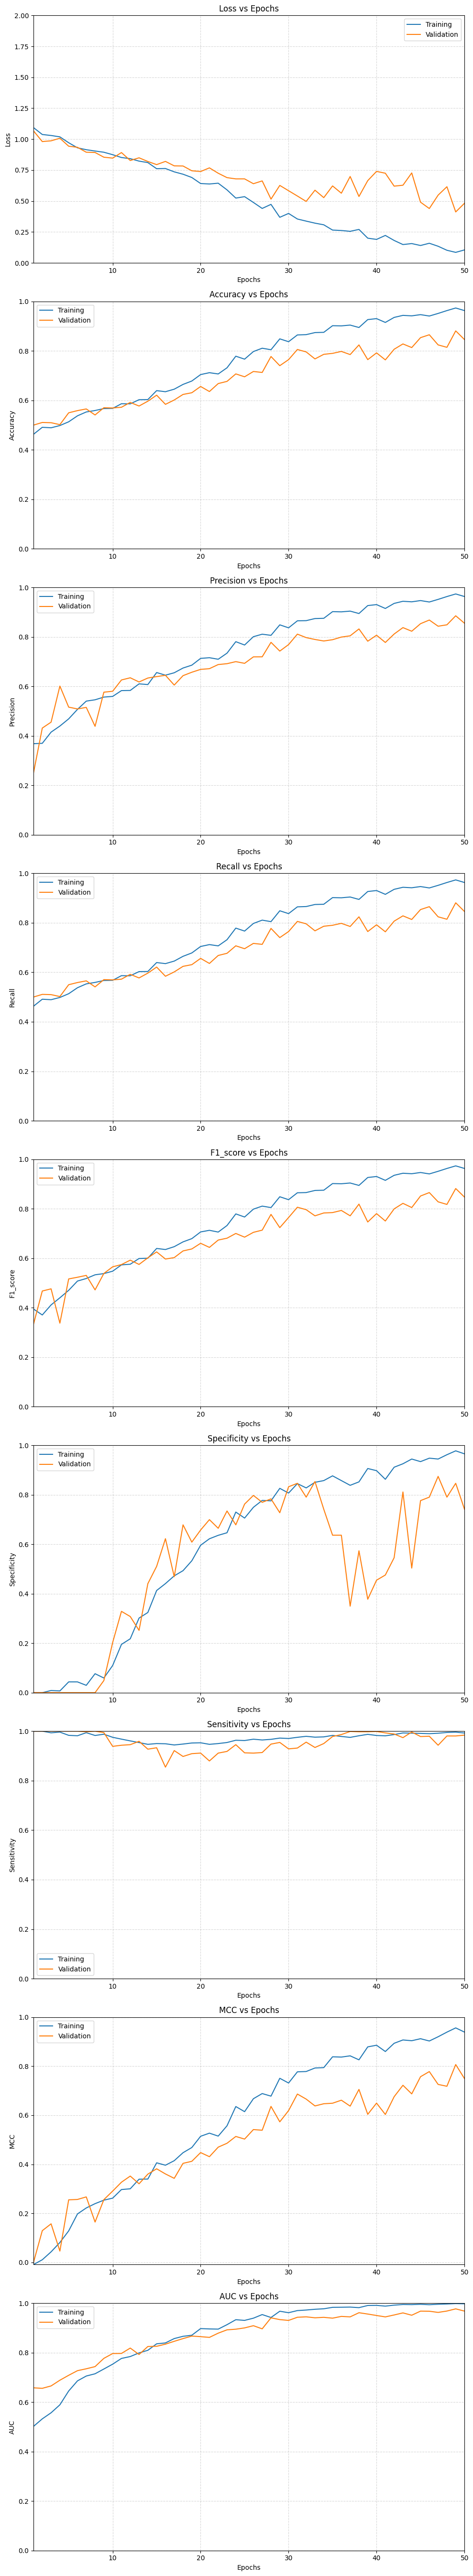

In [24]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [25]:
# Confusion Matrix
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

# Plot Confusion Matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

NameError: name 'classes' is not defined

<Figure size 500x500 with 0 Axes>